In [1]:
# import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset
results = pd.read_csv('../data/results.csv',encoding = "utf-8")



In [2]:
# this is to analyze how grid position influences final position
grid_cols = ['raceId', 'driverId', 'constructorId', 'grid', 'position']

grid_final = results[grid_cols]
grid_final.head()


,raceId,driverId,constructorId,grid,position
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


In [5]:
grid_final = grid_final.copy() # create a copy to avoid changing the original

In [8]:
# remove null values
grid_final.replace('\\N', np.nan, inplace=True)
grid_final.dropna(inplace=True)

# Filter out rows where 'grid' or 'position' is zero
# Either cause driver didn't participate or finish the race
grid = grid_final[(grid_final['grid'] != 0) & (grid_final['position'] != 0)]

grid = grid.copy()
# change any float objects to integer
grid['grid'] = grid['grid'].astype(int)
grid['position'] = grid['position'].astype(int)

In [9]:
# Filter the dataset for pole positions (grid position 1)
pole_positions = grid[grid['grid'] == 1]

# Count the number of times the pole position resulted in a win (positionOrder 1)
pole_wins = pole_positions[pole_positions['position'] == 1].shape[0]

# Print out the number of pole position wins
print(f"Number of wins from pole position: {pole_wins}")


Number of wins from pole position: 468


In [10]:
# Calculate the total number of races that had a pole position (for normalization)
total_pole_positions = pole_positions.shape[0]

# Calculate the percentage of races won from pole position
percentage_pole_wins = (pole_wins / total_pole_positions) * 100

# Print out the percentage of races won from pole position
print(f"Percentage of races won from pole position: {percentage_pole_wins:.2f}%")

Percentage of races won from pole position: 55.32%


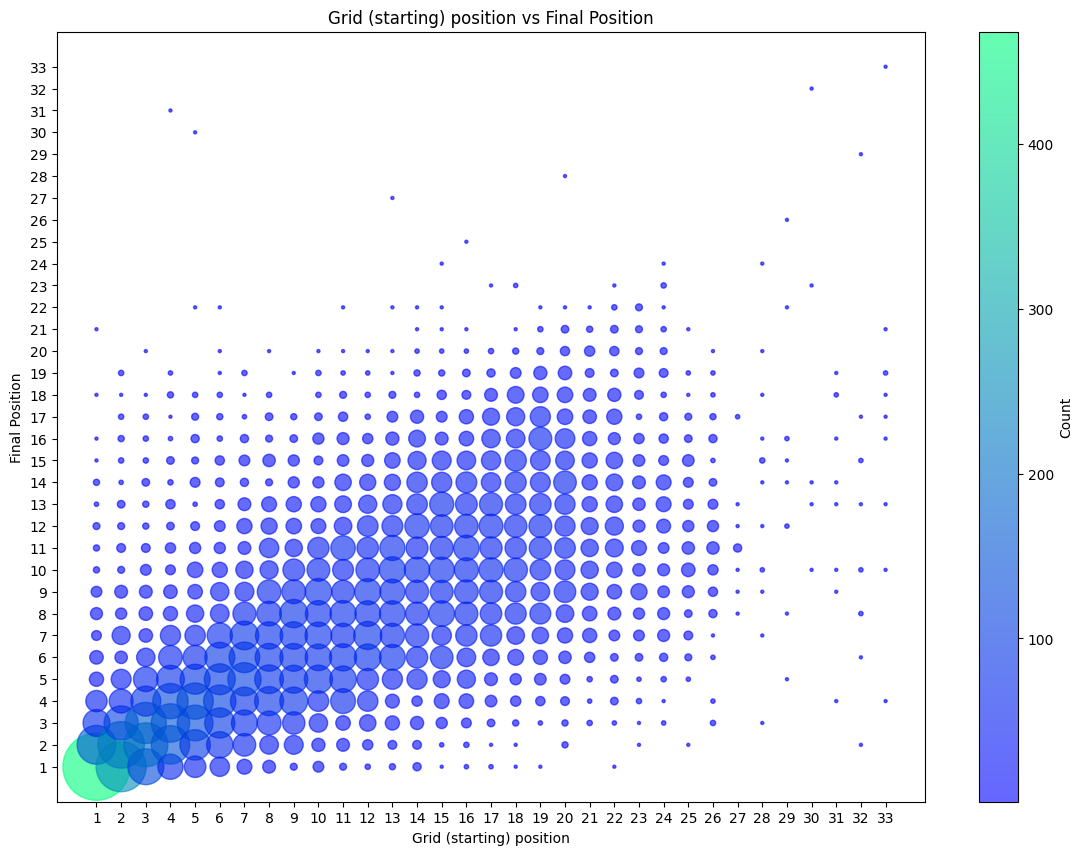

In [11]:
# Visualize
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Counting occurrences of each pair
df = pd.DataFrame({'X': grid['grid'], 'y': grid['position']})
counts = df.groupby(['X', 'y']).size().reset_index(name = 'counts')

# Plotting
size_scale = 5  # Adjust the size scale for visibility
norm = Normalize(vmin = counts['counts'].min(), vmax = counts['counts'].max())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(counts['X'], counts['y'], s = counts['counts'] * size_scale, 
                    c = counts['counts'], cmap = 'winter', norm = norm, alpha = 0.6)

# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Count')

# Discrete axis with integers
plt.xticks(np.arange(min(counts['X']), max(counts['X'])+1, 1))
plt.yticks(np.arange(min(counts['y']), max(counts['y'])+1, 1))
plt.xlabel('Grid (starting) position')
plt.ylabel('Final Position')
plt.title('Grid (starting) position vs Final Position')
plt.show()